SCHEDULING O(M*J*T)

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):

        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):

        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [6]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 1
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
M = 1
J = 2
E = [(0,1)]
run_times = np.array([1,1])
####

#### TEST 2 - 18 qubits PASSED
M = 2
J = 3
E = [(1,0), (2,1)]
run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = xy_method_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.xy_method_scheduling_problem'>
Used 20 qubits


In [7]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue(eigenvector, H):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [8]:
#from scipy.linalg import eigh
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")

Extract diagonal kronker
Finish 83.8s
Find mininum eigenvalue (numpy min)
Finish 0.1s
Minimum Eigenvalue: -13198.0
===Problem===
Run 3(+1 dummy) jobs on 2 machines.
Job Lengths: [1 1 0]
Dependency Graph [(1, 0), (2, 1), (0, 3), (1, 3), (2, 3)]
===
Quantum State (computational basis): |01011001011010000001>
M=2, J=4, T=3
X=01011001, Y=011010000001
===Solution===
t=0: Job #1 -> Machine #1
t=0: Job #2 -> Machine #0
t=1: Job #0 -> Machine #1
t=2: Job #dummy -> Machine #1
===end===


In [9]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

In [ ]:
def vector_to_spherical_angles(v):
    # Ensure the input is a numpy array and normalized
    v = np.asarray(v)
    assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
    n = len(v)
    angles = np.zeros(n - 1)

    # Calculate the angles
    for i in range(0, n - 1):
        # Calculate the angle theta_i
        # Use the norm of the remaining dimensions
        norm_remaining = np.linalg.norm(v[i+1:])
        angles[i] = np.arctan2(norm_remaining, v[i])
    
    return angles

def spherical_angles_to_vector(angles):
    # Ensure the input is a numpy array
    angles = np.asarray(angles)
    n = len(angles) + 1  # Number of dimensions
    
    # Initialize the unit vector
    v = np.zeros(n)
    
    # Calculate the first coordinate
    v[0] = np.cos(angles[0])
    
    # Calculate the remaining coordinates
    for i in range(1, n):
        # Compute the product of sines for the previous angles
        if i < n - 1:
            sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
            v[i] = sin_product * np.cos(angles[i])
        else:
            # For the last coordinate, we use the product of sines for all previous angles
            v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

    return v

test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
print(vector_to_spherical_angles(test_v))
print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

def get_directions(v, step_size):
    # Ensure the input is a numpy array
    v = np.asarray(v)
    directions = []
    
    # Iterate over each element in the vector
    for i in range(len(v)):
        # Create a copy of the original vector
        v_plus = v.copy()
        v_minus = v.copy()
        
        # Modify the i-th element
        v_plus[i] += step_size
        v_minus[i] -= step_size
        
        # Append the new vectors to the directions list
        directions.append(v_plus)
        directions.append(v_minus)
    
    return directions

def optimizer(H, initial_guess, step_size=0.01):
    best_vector_angles = vector_to_spherical_angles(initial_guess)
    best_value = get_eigenvalue(initial_guess, H)
    
    #print(best_value)
    
    for iterations in range(500):
        #Pick best direction
        for nearby_step in get_directions(best_vector_angles, step_size):
            new_value = get_eigenvalue(spherical_angles_to_vector(nearby_step), H)
            if(best_value > new_value):
                best_value = new_value
                best_vector_angles = nearby_step
        #print(best_vector_angles)
    
    return best_value, spherical_angles_to_vector(best_vector_angles)

[1.10714872 0.65905804]
[ True  True  True]


In [63]:
#from scipy.optimize import minimize
#
#def 

In [66]:
H_diag = np.array([1,-1])
initial = np.array([1,1]) / np.sqrt(2)


optimizer(H_diag, initial)

0.0
[0.78639816]
[0.78739816]
[0.78839816]
[0.78939816]
[0.79039816]
[0.79139816]
[0.79239816]
[0.79339816]
[0.79439816]
[0.79539816]
[0.79639816]
[0.79739816]
[0.79839816]
[0.79939816]
[0.80039816]
[0.80139816]
[0.80239816]
[0.80339816]
[0.80439816]
[0.80539816]
[0.80639816]
[0.80739816]
[0.80839816]
[0.80939816]
[0.81039816]
[0.81139816]
[0.81239816]
[0.81339816]
[0.81439816]
[0.81539816]
[0.81639816]
[0.81739816]
[0.81839816]
[0.81939816]
[0.82039816]
[0.82139816]
[0.82239816]
[0.82339816]
[0.82439816]
[0.82539816]
[0.82639816]
[0.82739816]
[0.82839816]
[0.82939816]
[0.83039816]
[0.83139816]
[0.83239816]
[0.83339816]
[0.83439816]
[0.83539816]
[0.83639816]
[0.83739816]
[0.83839816]
[0.83939816]
[0.84039816]
[0.84139816]
[0.84239816]
[0.84339816]
[0.84439816]
[0.84539816]
[0.84639816]
[0.84739816]
[0.84839816]
[0.84939816]
[0.85039816]
[0.85139816]
[0.85239816]
[0.85339816]
[0.85439816]
[0.85539816]
[0.85639816]
[0.85739816]
[0.85839816]
[0.85939816]
[0.86039816]
[0.86139816]
[0.86239

(np.float64(-0.8414709848078628), array([0.28153953, 0.95954963]))

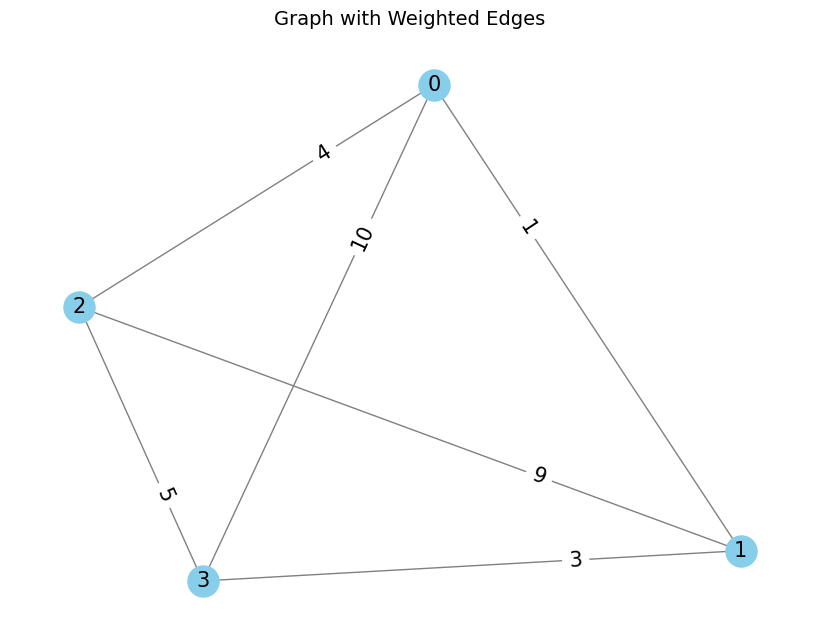

: 

In [ ]:
E = [(0, 1), (0, 3),(0,2), (1, 2),(1,3), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5,(0,2):4,(1,3):3}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


In [ ]:

vector_to_quantum_state([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'|0100>'

: 

In [ ]:
from ipynb.fs.full.ansatz import get_twolocal
from qiskit.quantum_info import SparsePauliOp
import networkx as nx
import random

from hamiltonians import gen_trans_ising_op, get_exact_ground, gen_maxcut_op, gen_maxcut_op_from_graph
from experiment_utils import *

random.seed(5)
TSP_landscape = run_and_record_landscape(H_total_TSP_full_graph, n_mub_qubits=3, desc="TSP Hamiltonian full graph, 9 qubits")

NameError: name 'H_total_TSP_full_graph' is not defined

: 

In [ ]:
E = [(0, 1), (0, 3), (1, 2), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


: 

In [ ]:
N = 4
num_qubits=(N-1)**2
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1), (0, 3), (1, 2), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5}
A = max(W.values())*len(E)


# Calculate each Hamiltonian term
H_verices_term_p = H_vertices_TSP(num_qubits,N,A)
H_time_term_p = H_time_TSP(num_qubits,N,A)
H_pen_term_p=H_pen_TSP(num_qubits,N,A,E)
H_pen_depot_term_p=H_Pen_depot_TSP(num_qubits,N,A,E)
H_weight_term_p=H_weight_TSP(num_qubits,N,A,E,W)
H_Weight_depot_term_p=H_Weight_depot_TSP(num_qubits,N,A,E,W)

# Sum up to get the total Hamiltonian
H_total_TSP_partial_graph = H_verices_term_p + H_time_term_p + H_pen_term_p + H_pen_depot_term_p + H_weight_term_p +H_Weight_depot_term_p


random.seed(5)
TSP_landscape_partial = run_and_record_landscape(H_total_TSP_partial_graph, n_mub_qubits=3, desc="TSP Hamiltonian -not full graph, 9 qubits")


: 

In [ ]:
#####################################################################################


: 

VRP HAMILTONIAN

VRP With N(N+k-1) qubits - not relevant anymore!

In [ ]:
# #VRP With N(N+k-1) qubits - use it if the other version give weird results.
# import numpy as np
# from qiskit.quantum_info import SparsePauliOp
# from itertools import product
# import networkx as nx
# import matplotlib.pyplot as plt

# # Define identity and Z matrices as Pauli strings
# Z = 'Z'
# I = 'I'

# # Function to generate SparsePauliOp
# def kronecker_product(operators, coeff, N):
#     # Construct the Pauli string by joining the operators
#     pauli_string = ''.join(operators)

#     # Create the SparsePauliOp with the given coefficient
#     return SparsePauliOp.from_list([(pauli_string, coeff)],num_qubits=N)
# def H_start(num_qubits, A):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A/2)])
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     operators = [I if (i != 0) else Z for i in range(num_qubits)]
#     term += kronecker_product(operators, A / 2,num_qubits)
#     return identity_term + term
# def H_B(num_qubits,A,k,T,N_t):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*(k**2-k*T+(T**2)/4))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         operators = [I if (i != 0 * T + j) else Z for i in range(num_qubits)]
#         term2 += kronecker_product(operators, (A/2)*(2*k-T) , num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for i in range(0,T):
#             operators = [I if (j == i) else I if(l != 0 * T + j and l != 0 * T + i) else Z for l in range(num_qubits)]
#             term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3
# def H_C(num_qubits,N, A,k,T,N_t):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A * (N-1) * (1- T + (T**2) / 4))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for v in range(1,N):
#         for j in range(0,T):
#             operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
#             term2 += kronecker_product(operators, A * (2-T) / 2, num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for v in range(1,N):
#         for j in range(0,T):
#             for i in range(0,T):
#                 operators = [I if (j == i) else I if(l != v * T + j and l != v * T + i) else Z for l in range(num_qubits)]
#                 term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3

# def H_D(num_qubits,N, A,k,T,N_t):
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*T*(1-N+(N**2/4)))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for v in range(0,N):
#             operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
#             term2 += kronecker_product(operators, A * (2-N) / 2, num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for v in range(0,N):
#             for u in range(0,N):
#                 operators = [I if ((l != v * T + j and l != u * T + j) or v == u) else Z for l in range(num_qubits)]
#                 term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3

# def H_E(num_qubits,N, A,k,T,N_t,E):
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for u, v in product(range(N), repeat=2):
#         if (u, v) not in E and (v, u) not in E and u != v:
#             for j in range(0,T):
#                 operators = [I] * num_qubits
#                 operators[u * T + j] = Z
#                 operators[v * T + ((j + 1) % T)] = Z
#                 t1 = kronecker_product(operators, 1, num_qubits)

#                 operators = [I] * num_qubits
#                 operators[u * T + j] = Z
#                 t2 = kronecker_product(operators, -1, num_qubits)

#                 operators = [I] * num_qubits
#                 operators[v * T + ((j + 1) % T)] = Z
#                 t3 = kronecker_product(operators, -1, num_qubits)

#                 term += A / 4 * (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 1)],num_qubits=num_qubits))

#     return term

# def H_F(num_qubits,N, A,k,T,N_t,E,W):
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for (u, v) in E:
#         for j in range(0,T):
#             operators = [I] * num_qubits
#             operators[u * T + j] = Z
#             operators[v * T + ((j + 1) % T)] = Z
#             t1 = kronecker_product(operators, W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[u * T + j] = Z
#             t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[v * T + ((j + 1) % T)] = Z
#             t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

#     for (u, v) in E:
#         for j in range(0,T):
#             operators = [I] * num_qubits
#             operators[v * T + j] = Z
#             operators[u * T + ((j + 1) % T)] = Z
#             t1 = kronecker_product(operators, W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[v * T + j] = Z
#             t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[u * T + ((j + 1) % T)] = Z
#             t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

#     return term

# # Define a sample graph
# N = 4  # Number of vertices (including depot)
# k = 1    # Number of vehicles
# N_t = k + N
# T = N_t - 1    # T = k + N - 1

# # Define the edges and weights
# #E = [(0, 1), (0, 2), (1, 2)]
# #W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# # Define edges of the graph

# # the weights and edges writing should be (i,j) such that i<j !!
# # ensure N coreesponds the right number of vertices in E,W
# E = [(0, 1), (1, 3), (0, 3), (1, 2), (0, 2), (2, 3)]

# # Define the corresponding weights for the edges
# W = {(0, 1): 2, (1, 2): 3, (0, 2): 4, (0, 3): 3, (1, 3): 1, (2, 3): 5}

# A=max(W.values())*len(E)+1
# num_qubits=N*T


# # Calculate each Hamiltonian term
# H_start_term = H_start(num_qubits,A)
# H_B_term = H_B(num_qubits,A,k,T,N_t)
# H_C_term = H_C(num_qubits,N,A,k,T,N_t)
# H_D_term = H_D(num_qubits,N,A,k,T,N_t)
# H_E_term = H_E(num_qubits,N,A,k,T,N_t,E)
# H_F_term = H_F(num_qubits,N,A,k,T,N_t,E,W)

# # Sum up to get the total Hamiltonian
# H_total = H_start_term + H_B_term + H_C_term + H_D_term +H_E_term+H_F_term

: 

In [ ]:
# def draw_graph(E, W):
#     G = nx.Graph()
#     G.add_edges_from(E)

#     pos = nx.spring_layout(G)  # positions for all nodes
#     labels = {}

#     # Add edge weights, accounting for both (u, v) and (v, u) keys in the weight dictionary
#     for edge in G.edges:
#         if edge in W:
#             labels[edge] = W[edge]
#         elif (edge[1], edge[0]) in W:  # Check the reverse of the edge
#             labels[edge] = W[(edge[1], edge[0])]

#     nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

#     plt.title("Graph Representation of the Problem")
#     plt.show()
# draw_graph(E,W)



: 

In [ ]:
# import numpy as np
# from qiskit.quantum_info import SparsePauliOp

# # Function to compute all eigenvectors corresponding to the minimum eigenvalue
# def compute_all_minimum_eigenvectors(H_total, num_qubits):
#     # Convert SparsePauliOp to matrix
#     H_matrix = H_total.to_matrix()

#     # Perform eigenvalue decomposition
#     eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

#     # Find the minimum eigenvalue
#     min_eigenvalue = np.min(eigenvalues)

#     # Find all eigenvectors corresponding to the minimum eigenvalue
#     min_eigenvalue_indices = np.where(np.isclose(eigenvalues, min_eigenvalue))[0]
#     min_eigenvectors = eigenvectors[:, min_eigenvalue_indices]

#     return min_eigenvalue, min_eigenvectors

# # Function to extract the path from a binary state vector
# def extract_route_from_statevector(binary_state, N, T):
#     # Initialize the route
#     route = []

#     # Iterate over timesteps (T)
#     for t in range(T):
#         # For each timestep, check which vertex is visited
#         for v in range(N):
#             # Each vertex has T bits in the state vector
#             if binary_state[v * T + t] == '1':  # Check if the bit is '1'
#                 route.append(v)
#                 break

#     # Always return to the depot (vertex 0) at the end
#     if route[-1] != 0:
#         route.append(0)

#     return route

# # Function to split the route into separate vehicle paths
# def split_route_for_vehicles(route):
#     vehicles = []
#     current_vehicle = []

#     # Iterate over the route and split at every return to vertex 0 (except the first occurrence)
#     for vertex in route:
#         current_vehicle.append(vertex)
#         if vertex == 0 and len(current_vehicle) > 1:
#             vehicles.append(current_vehicle)
#             current_vehicle = [0]  # Start a new vehicle's route with 0

#     return vehicles

# # Function to normalize and print all state vectors and their corresponding vehicle routes
# def print_all_minimum_state_vectors_and_paths(min_eigenvectors, min_eigenvalue, num_qubits, N, T):
#     # Get the expected length of the state vector for a system
#     expected_state_vector_length = 2 ** num_qubits

#     # Loop over all minimum eigenvectors
#     for idx, min_eigenvector in enumerate(min_eigenvectors.T):
#         # Reduce the eigenvector to the expected length (if larger)
#         min_eigenvector_reduced = min_eigenvector[:expected_state_vector_length]

#         # Normalize the state vector
#         norm_min_eigenvector_reduced = min_eigenvector_reduced / np.linalg.norm(min_eigenvector_reduced)

#         # Find the computational basis states with significant amplitudes
#         significant_indices = np.where(np.abs(norm_min_eigenvector_reduced) > 1e-6)[0]  # Threshold for significant amplitudes

#         # Get the binary representations of these states
#         binary_states = [format(index, f'0{num_qubits}b') for index in significant_indices]

#         # Output the minimum eigenvalue and the states
#         print(f"Minimum eigenvalue: {min_eigenvalue}")
#         print(f"Corresponding non-zero computational basis states and amplitudes for eigenvector {idx + 1}:")
#         for index, state in zip(significant_indices, binary_states):
#             amplitude = norm_min_eigenvector_reduced[index]
#             print(f"State: |{state}> with amplitude: {amplitude}")

#             # Extract the path based on the binary state
#             route = extract_route_from_statevector(state, N, T)

#             # Split the route for each vehicle
#             vehicles = split_route_for_vehicles(route)

#             # Print each vehicle's route
#             for vehicle_idx, vehicle_route in enumerate(vehicles, 1):
#                 vehicle_route_str = ' -> '.join(map(str, vehicle_route))
#                 print(f"Vehicle {vehicle_idx}: {vehicle_route_str}")

#         print("\n" + "="*60 + "\n")


# # Compute the minimum eigenvalue and all corresponding eigenvectors
# min_eigenvalue, min_eigenvectors = compute_all_minimum_eigenvectors(H_total, num_qubits)

# # Print the corresponding binary state vectors and amplitudes for a system, along with extracted paths
# print_all_minimum_state_vectors_and_paths(min_eigenvectors, min_eigenvalue, num_qubits, N, T)


: 

VRP Newer version - N(N+k-2) qubits - Relevant version!

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt

# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)],num_qubits=N)
def H_vehicle_constraint(num_qubits,A,k,T):
    # Start with the identity term (coefficient times identity)
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*((k-1)**2-(k-1)*T+(T**2)/4))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        operators = [I if (i != 0 * T + j) else Z for i in range(num_qubits)]
        term2 += kronecker_product(operators, (A/2)*(2*(k-1)-T) , num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for i in range(0,T):
            operators = [I if (j == i) else I if(l != 0 * T + j and l != 0 * T + i) else Z for l in range(num_qubits)]
            term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3
def H_vertices_constraint(num_qubits,N, A,T):
    # Start with the identity term (coefficient times identity)
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A * (N-1) * (1- T + (T**2) / 4))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(1,N):
        for j in range(0,T):
            operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
            term2 += kronecker_product(operators, A * (2-T) / 2, num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(1,N):
        for j in range(0,T):
            for i in range(0,T):
                operators = [I if (j == i) else I if(l != v * T + j and l != v * T + i) else Z for l in range(num_qubits)]
                term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3

def H_time_constraint(num_qubits,N, A,T):
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*T*(1-N+(N**2/4)))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for v in range(0,N):
            operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
            term2 += kronecker_product(operators, A * (2-N) / 2, num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for v in range(0,N):
            for u in range(0,N):
                operators = [I if ((l != v * T + j and l != u * T + j) or v == u) else Z for l in range(num_qubits)]
                term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3

def H_edges_constraint(num_qubits,N, A,T,E):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for u, v in product(range(N), repeat=2):
        if (u, v) not in E and (v, u) not in E and u != v:
            for j in range(0,T-1):
                operators = [I] * num_qubits
                operators[u * T + j] = Z
                operators[v * T + ((j + 1) % T)] = Z
                t1 = kronecker_product(operators, 1, num_qubits)

                operators = [I] * num_qubits
                operators[u * T + j] = Z
                t2 = kronecker_product(operators, -1, num_qubits)

                operators = [I] * num_qubits
                operators[v * T + ((j + 1) % T)] = Z
                t3 = kronecker_product(operators, -1, num_qubits)

                term += A / 4 * (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 1)],num_qubits=num_qubits))

    return term
def H_depot_edges_constraint(num_qubits,N, A,T,E):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(0,N):
        if (0, v) not in E and (v, 0) not in E:
            operators = [I] * num_qubits
            operators[v * T] = Z
            t2 = kronecker_product(operators, -1, num_qubits)

            operators = [I] * num_qubits
            operators[v * T + (T-1)] = Z
            t3 = kronecker_product(operators, -1, num_qubits)

            term += A / 2 * (t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 2)],num_qubits=num_qubits))

    return term

def H_weights(num_qubits,T,E,W):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for (u, v) in E:
        for j in range(0,T-1):
            operators = [I] * num_qubits
            operators[u * T + j] = Z
            operators[v * T + ((j + 1) % T)] = Z
            t1 = kronecker_product(operators, W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[u * T + j] = Z
            t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + ((j + 1) % T)] = Z
            t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

            term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

    for (u, v) in E:
        for j in range(0,T-1):
            operators = [I] * num_qubits
            operators[v * T + j] = Z
            operators[u * T + ((j + 1) % T)] = Z
            t1 = kronecker_product(operators, W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + j] = Z
            t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[u * T + ((j + 1) % T)] = Z
            t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

            term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

    return term
def H_Weight_depot(num_qubits,T,E,W):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for (u, v) in E:
        if(u==0):
            operators = [I] * num_qubits
            operators[v * T] = Z
            t2 = kronecker_product(operators, -W[(0, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + T-1] = Z
            t3 = kronecker_product(operators, -W[(0, v)], num_qubits)

            term += (t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 2*W[(0, v)])],num_qubits=num_qubits)) / 2

    return term


: 

In [ ]:

# Define a sample graph
N = 4  # Number of vertices (including depot)
k=1
# Number of vehicles

T = k+N-2

# Define the edges and weights
#E = [(0, 1), (0, 2), (1, 2)]
#W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# Define edges of the graph
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1),  (0, 3), (1, 2), (2, 3),(1,3),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 9,  (2, 3): 5, (0, 3): 10,(1,3): 3, (0,2): 4}

A=T*max(W.values())+1 # should be > max(W) * (N+k-2)
num_qubits=N*T


# Calculate each Hamiltonian term
h_vehicle_constraint = H_vehicle_constraint(num_qubits,A,k,T)
h_vertices_constraint = H_vertices_constraint(num_qubits,N,A,T)
h_time_constraint = H_time_constraint(num_qubits,N,A,T)
h_edges_constraint = H_edges_constraint(num_qubits,N,A,T,E)
h_weight_term = H_weights(num_qubits,T,E,W)
h_depot_edges_constraint=H_depot_edges_constraint(num_qubits,N,A,T,E)
h_Weight_Dep = H_Weight_depot(num_qubits,T,E,W)
# Sum up to get the total Hamiltonian
H_total_4_vertices_k1 =  h_vehicle_constraint + h_vertices_constraint + h_time_constraint +h_edges_constraint+h_weight_term + h_depot_edges_constraint + h_Weight_Dep


: 

In [ ]:
E = [(0, 1), (0, 3),(0,2), (1, 2),(1,3), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5,(0,2):4,(1,3):3}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


: 

In [ ]:
VRP_landscape_4vertices_k1 = run_and_record_landscape(H_total_4_vertices_k1, n_mub_qubits=3, desc="VRP Hamiltonian Full graph 4 vertices k=1, 12 qubits")

: 

In [ ]:
N = 3  # Number of vertices (including depot)
k= 2
# Number of vehicles

T = N+k-2

# Define the edges and weights
#E = [(0, 1), (0, 2), (1, 2)]
#W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# Define edges of the graph
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1),  (1, 2),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 4, (0,2): 9}

A=T*max(W.values()) # should be > max(W) * (N+k-2)
num_qubits=N*T


# Calculate each Hamiltonian term
h_vehicle_constraint = H_vehicle_constraint(num_qubits,A,k,T)
h_vertices_constraint = H_vertices_constraint(num_qubits,N,A,T)
h_time_constraint = H_time_constraint(num_qubits,N,A,T)
h_edges_constraint = H_edges_constraint(num_qubits,N,A,T,E)
h_weight_term = H_weights(num_qubits,T,E,W)
h_depot_edges_constraint=H_depot_edges_constraint(num_qubits,N,A,T,E)
h_Weight_Dep = H_Weight_depot(num_qubits,T,E,W)
# Sum up to get the total Hamiltonian
H_total_3vertices_k2 =  h_vehicle_constraint + h_vertices_constraint + h_time_constraint +h_edges_constraint+h_weight_term + h_depot_edges_constraint + h_Weight_Dep

: 

In [ ]:
E = [(0, 1),  (1, 2),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 4, (0,2): 9}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


: 

In [ ]:
VRP_landscape_3vertices_k2 = run_and_record_landscape(H_total_3vertices_k2, n_mub_qubits=3, desc="VRP Hamiltonian Full graph 3 vertices k=2, 9 qubits")

: 

In [ ]:
# ## a self check code - for the correct solution only H_weight_depot and H_F should have energy

# # Function to compute the expectation value (eigenvalue) of a given state
# def compute_eigenvalue_for_state(H_total, binary_state):
#     # Convert binary state string to state vector
#     num_qubits = len(binary_state)
#     state_vector = np.zeros(2 ** num_qubits, dtype=complex)

#     # Find the index of the state in the computational basis
#     index = int(binary_state, 2)

#     # Set the corresponding element in the state vector to 1 (representing |000100010001>)
#     state_vector[index] = 1.0

#     # Convert SparsePauliOp to matrix
#     H_matrix = H_total.to_matrix()

#     # Compute the expectation value <state|H|state>
#     expectation_value = np.vdot(state_vector, H_matrix @ state_vector)

#     return np.real(expectation_value)

# # Define the binary state |000100010001>
# #binary_state = '000100010001'

# # Define the binary state |000100010001>
# binary_state = '001010100'

# # Compute the eigenvalue for the given state
# min_eigenvalue1 = compute_eigenvalue_for_state(H_B_term, binary_state)
# min_eigenvalue2 = compute_eigenvalue_for_state(H_C_term, binary_state)
# min_eigenvalue3 = compute_eigenvalue_for_state(H_D_term, binary_state)
# min_eigenvalue4 = compute_eigenvalue_for_state(H_E_term, binary_state)
# min_eigenvalue5 = compute_eigenvalue_for_state(H_F_term, binary_state)
# min_eigenvalue6 = compute_eigenvalue_for_state(H_Pen_depot(num_qubits,N,A,k,T,N_t,E), binary_state)
# min_eigenvalue7 = compute_eigenvalue_for_state(H_Weight_depot(num_qubits,N,A,k,T,N_t,E,W), binary_state)


# # Print the result
# print(f"The minimum eigenvalue is: {min_eigenvalue1}")
# print(f"The minimum eigenvalue is: {min_eigenvalue2}")
# print(f"The minimum eigenvalue is: {min_eigenvalue3}")
# print(f"The minimum eigenvalue is: {min_eigenvalue4}")
# print(f"The minimum eigenvalue is: {min_eigenvalue5}")
# print(f"The minimum eigenvalue is: {min_eigenvalue6}")
# print(f"The minimum eigenvalue is: {min_eigenvalue7}")

: 